In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import chromadb
import json
import pandas as pd
import matplotlib.pyplot as plt
from chromadb.utils.data_loaders import ImageLoader
from weavingtools.embedding_tools import SigLIPEmbedder
from weavingtools.weaving_tools import plot_query_results
import scipy.spatial as sp
import seaborn as sns
import numpy as np
sns.set()

/Users/kasparbeelen/anaconda3/envs/heritageweaver/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="ce_comms_db")

data_loader = ImageLoader()

collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

# Check database

In [5]:
collection_df = pd.read_csv('data/communications_data.csv')

In [6]:
collection_df.shape[0], collection_db.count()

(5414, 26928)

# Compare a pair of items across modalities

In [7]:
data = collection_db.get()# where={'collection':'smg'}

In [8]:
#idx1, idx2 = 100, 8003

In [9]:
rids = [record['record_id'] for record in data['metadatas']]
ids = data['ids']
r1 = collection_db.get(where={'record_id':'co8427235'},include=['embeddings','metadatas'])
r2 = collection_db.get(where={'record_id':'T.1909.5.2'},include=['embeddings','metadatas'])
im_1 = [r['input_modality'] for r in r1['metadatas']]
im_2 = [r['input_modality'] for r in r2['metadatas']]
sent_1 = [r.get('sentence','image') for r in r1['metadatas']]
sent_2 = [r.get('sentence','image') for r in r2['metadatas']]
r1_emb = np.matrix(r1['embeddings'])
r2_emb = np.matrix(r2['embeddings'])
mult = 1 - sp.distance.cdist(r1_emb,r2_emb, 'cosine')

In [10]:
similiarities = list(zip(*np.where(mult > 0.8)))
[(sent_1[i], sent_2[j], mult[i,j]) for i,j in similiarities]

[('Hughes typewriting telegraph instrument, unknown maker, 1860.',
  'One of a collection of telegraph and telephone apparatus and materials - an early form of ink writer',
  0.8292019415753027),
 ('Hughes typewriting telegraph instrument, 1860, invented about 1855 by David Edward Hughes (), patent number 938, 1858.',
  'One of a collection of telegraph and telephone apparatus and materials - an early form of ink writer',
  0.8259127628714884),
 ('Hughes typewriting telegraph instrument, 1860, invented about 1855 by David Edward Hughes (1829/31-1900), patent number 938, 1858.',
  'One of a collection of telegraph and telephone apparatus and materials - an early form of ink writer',
  0.8098232891714013),
 ('Hughes typewriting telegraph instrument, 1860, invented about 1855 by David Edward Hughes (1829/31-1900), patent number 938, 1858.',
  'One of a collection of telegraph and telephone apparatus and materials - an early form of ink writer',
  0.8098232891714013),
 ('1860; Hughes typew

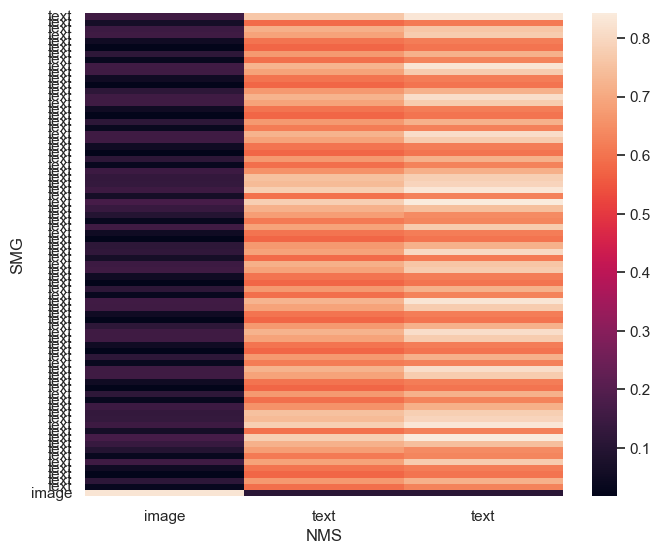

In [10]:
sns.set(rc={'figure.figsize':(7.7,6.27)})
ax = sns.heatmap(mult, yticklabels=im_1, xticklabels=im_2)
ax.set(xlabel='NMS', ylabel='SMG')
plt.show()

# Collection Level Comparison

In [11]:
from weavingtools.weaving_tools import compute_similarities
from weavingtools.annotation_tools import *
from weavingtools.weaving_tools import *
from tqdm.notebook import tqdm
import networkx as nx

In [12]:
def plot_record_pairs(record_pairs):
    fig, axes = plt.subplots(len(record_pairs), 2, figsize=(15, 15.5))
    
    for j in range(len(record_pairs)):
        for i in range(2):
            record = collection_df[collection_df.record_id==record_pairs[j][i]]
            img_path = record.img_path.values[0]
            description = soft_wrap_text( record.description.values[0]) # record.record_id.values[0] + ' '  +
            img = Image.open(img_path)
            axes[j,i].imshow(img)
            #axes[j,i].set_title(record.record_id.values[0], fontsize = 10)
            axes[j,i].set_title(description[:50], fontsize = 10)
            axes[j,i].axis('off')
         
    plt.show()



In [26]:
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'text','text' #'image', 'image' #
agg_func = 'max' # mean or max
percentile = 99.9  #99.95 | False
threshold = 0.8
tt_edges, tt_similarities, tt_inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, agg_func, percentile, threshold,); len(tt_edges)


Get inputs...
Compute similarities...
--- Get similarities ---
--- Using 0.8011024188687992 as threshold ---
--- Aggregate similarities by record ---
<class 'pandas.core.frame.DataFrame'>
--- Threshold similarities and binarize ---
Retrieve edges...


9786

In [27]:
coll1, coll2 = 'smg','nms'
modality1, modality2 = 'image','image' #'image', 'image' #
agg_func = 'max' # mean or max
percentile = 99.75  #99.95 | False
threshold = 0.8
ii_edges, ii_similarities, ii_inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, agg_func,percentile, threshold ); len(ii_edges)


Get inputs...
Compute similarities...
--- Get similarities ---
--- Using 0.8307377328149639 as threshold ---
--- Aggregate similarities by record ---
<class 'pandas.core.frame.DataFrame'>
--- Threshold similarities and binarize ---
Retrieve edges...


7382

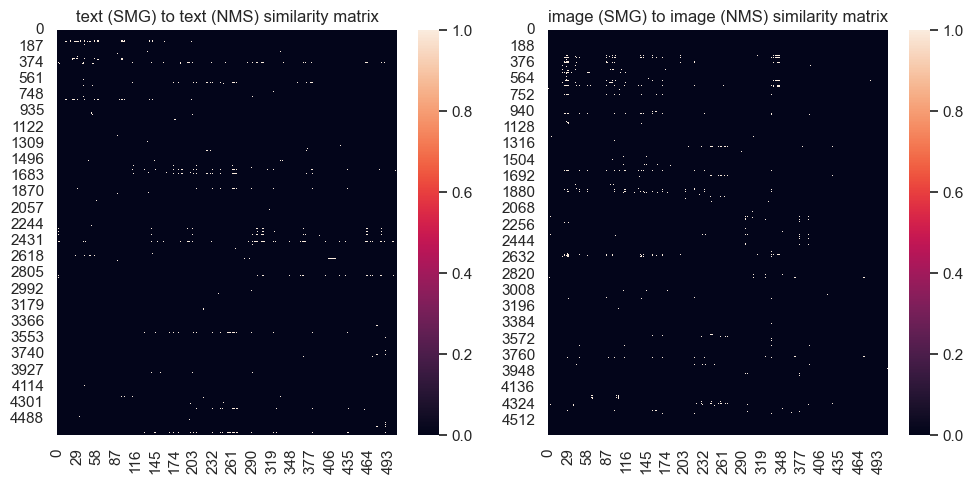

In [29]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first matrix
sns.heatmap(tt_similarities, ax=axs[0]) # , annot=True, cbar=False
axs[0].set_title('text (SMG) to text (NMS) similarity matrix')

# Plot the second matrix
sns.heatmap(ii_similarities, ax=axs[1]) # , annot=True, cbar=False
axs[1].set_title('image (SMG) to image (NMS) similarity matrix')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [19]:
def overlapping_edges(edges1, edges2):
    return [e for e in edges1 if e in edges2]

overlap = overlapping_edges(tt_edges, ii_edges)

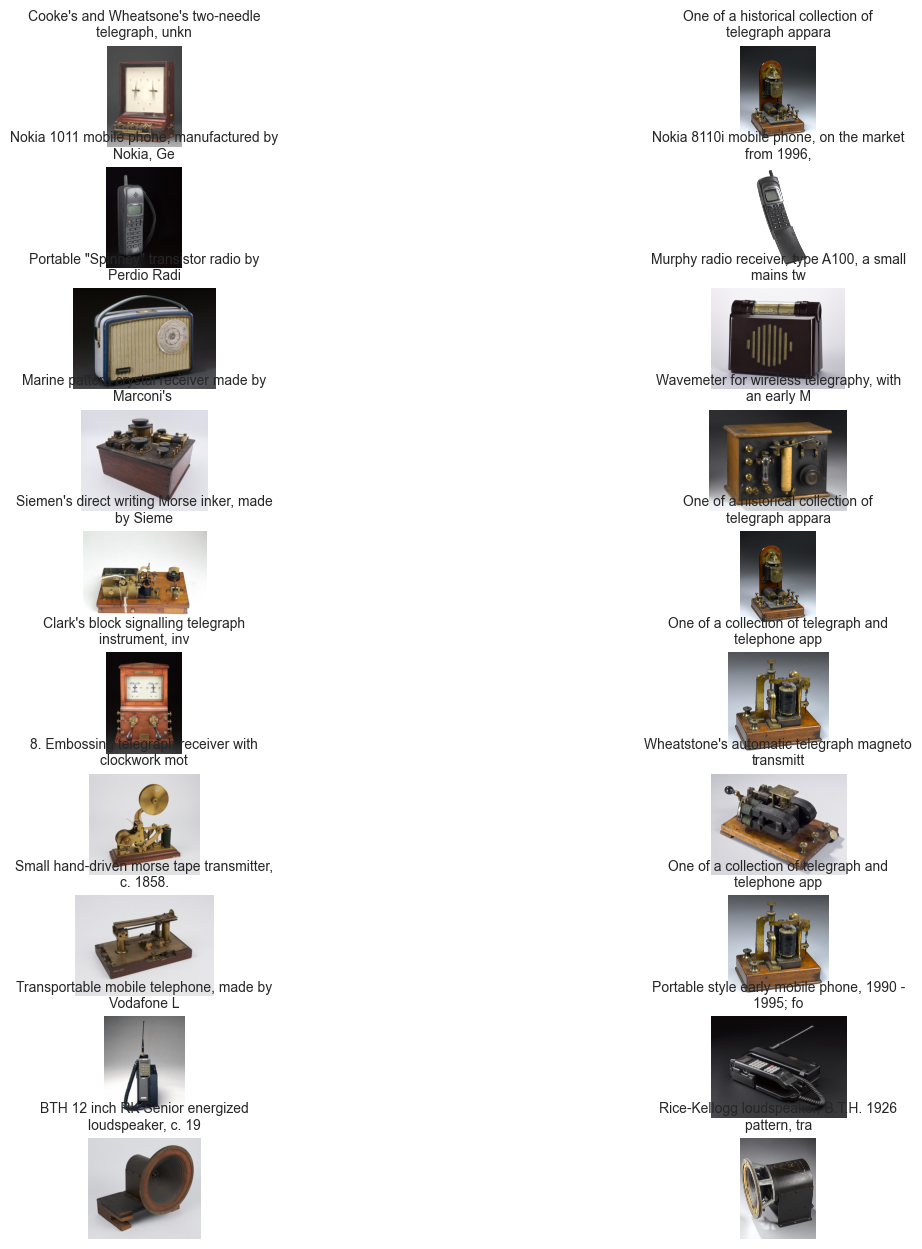

In [46]:
random.shuffle(overlap)
plot_record_pairs(overlap[:10])

In [40]:
random.shuffle(ii_edges)
record_pairs = list(ii_edges)[:5]
plot_record_pairs(record_pairs)

NameError: name 'ii_edges' is not defined

In [15]:
inputs = get_data(collection_db,coll1,coll2, modality1, modality2)
inputs, similarities = compute_similarities(inputs,percentile,agg_func)

--- Get similarities ---
--- Using 0.2327910250548801 as threshold ---
--- Aggregate similarities by record ---
<class 'pandas.core.frame.DataFrame'>
--- Threshold similarities and binarize ---


In [13]:
edges, image_similarities, inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, percentile, agg_func); len(edges)

17275

<Axes: >

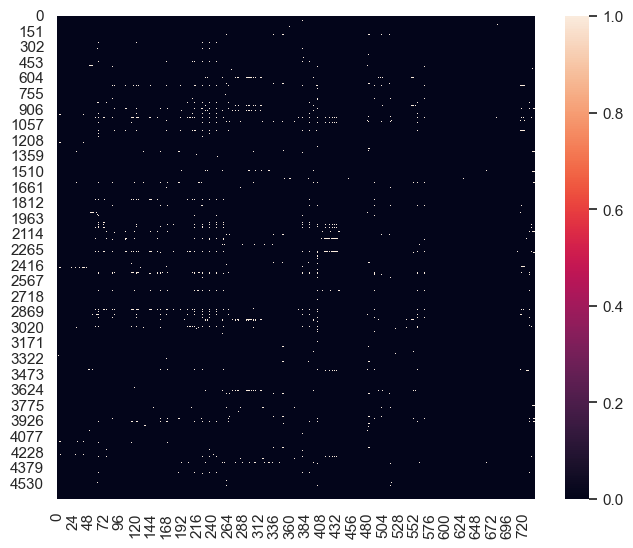

In [15]:
sns.heatmap(image_similarities)

In [12]:


def retrieve_records(coll,modality):   
    filters = {
        "$and": [
            {
                "input_modality": {
                    "$eq": modality
                }
            },
            {
                "collection": {
                    "$eq" : coll
                }
            }
            ]
        }

    return collection_db.get(
                where=filters,
                include=['embeddings','metadatas'] 
                    )


def get_data(coll1, coll2, modality1, modality2): 
    data1 = retrieve_records(coll1, modality1)
    data2 = retrieve_records(coll2, modality2)
    
    inputs = dict()
    
    for i,(name,data) in enumerate([(coll1, data1), (coll2,data2)]):
        i+=1
        inputs[f'coll{i}_ids'] = data['ids']
        inputs[f'coll{i}_rids'] = [record['record_id'] for record in data['metadatas']]
        inputs[f'coll{i}_emb'] = np.matrix(data['embeddings'])
        inputs[f'coll{i}_len'] = len(data['ids'])
        inputs[f'coll{i}_name'] = name
    
    return inputs

def create_graph(coll1, coll2, modality1, modality2, percentile=99.5):
    inputs = get_data(coll1, coll2, modality1, modality2)
    image_similarities = 1 - sp.distance.cdist(inputs['coll1_emb'],inputs['coll2_emb'], 'cosine')
    
    threshold = np.percentile(image_similarities.reshape(-1), percentile) 
    image_similarities_binary = image_similarities.copy()
    image_similarities_binary[image_similarities_binary >= threshold] = 1
    image_similarities_binary[image_similarities_binary < threshold] = 0
    edges = [(inputs['coll1_rids'][i],
              inputs['coll2_rids'][j]) 
                           for i,j in zip(*np.where(image_similarities_binary > 0))]
    
    coll1_node_ids = list(np.where(image_similarities_binary.sum(axis=1) > 0)[0])
    coll2_node_ids = list(np.where(image_similarities_binary.sum(axis=0) > 0)[0])
    
    # is there a more elegant way for doing this?
    coll1_mapping = {i:j for i,j in zip(range(inputs['coll1_len']),inputs['coll1_rids'])}
    coll2_mapping = {i:j for i,j in zip(range(inputs['coll2_len']),inputs['coll2_rids'])}
    
    G = nx.Graph()
    
    G.add_edges_from([(i,j) for i,j in tqdm(edges)])

    G.add_nodes_from([(coll1_mapping[nid],  
                {#'url' : collection_df[collection_df.record_id==coll1_mapping[nid]].img_url.values[0], 
                 'color':'blue', 'collection': inputs['coll1_name'],
                })
                 for nid in tqdm(coll1_node_ids)])

    G.add_nodes_from([(coll2_mapping[nid], 
                 {#'url' : collection_df[collection_df.record_id==coll2_mapping[nid]].img_url.values[0],
                  'color':'red', 'collection': inputs['coll2_name'],
                 })
               for nid in tqdm(coll2_node_ids)])

    return G, image_similarities_binary

G, img_sim_bin = create_graph('smg','nms','image','image')

  0%|          | 0/31440 [00:00<?, ?it/s]

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

In [13]:
G12, img_sim_bin12 = create_graph('smg','nms','image','image')
G11, img_sim_bin11 = create_graph('smg','smg','image','image')
G22, img_sim_bin22 = create_graph('nms','nms','image','image')


  0%|          | 0/31440 [00:00<?, ?it/s]

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

  0%|          | 0/109279 [00:00<?, ?it/s]

  0%|          | 0/4675 [00:00<?, ?it/s]

  0%|          | 0/4675 [00:00<?, ?it/s]

  0%|          | 0/9047 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

<Axes: >

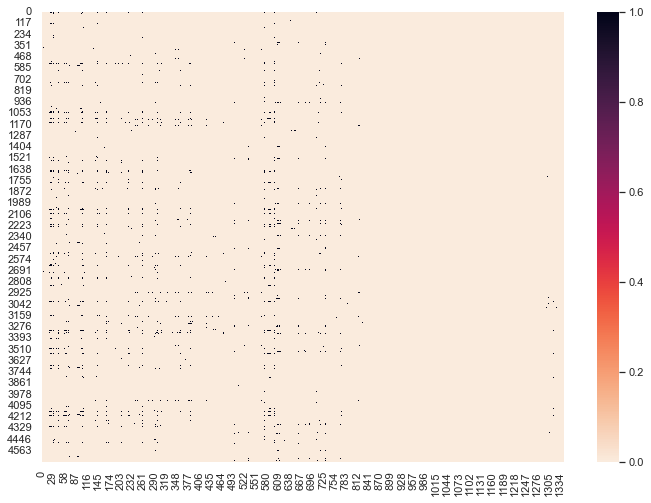

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(img_sim_bin12, cmap= sns.cm.rocket_r)

In [357]:
G_12_11 = nx.compose(G12, G11)

In [358]:
G_all = nx.compose(G_12_11, G22)

In [359]:
nx.write_gexf(G_all, "test2.gexf"), 

(None,)

# Older stuff

In [323]:
modality = 'image'
coll1 = 'smg'
coll2 = 'nms'

filter_smg = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality
            }
        },
        {
            "collection": {
                "$eq" : coll1
            }
        }
    ]
}


smg_data = collection_db.get(
                where=filter_smg,
                include=['embeddings','metadatas']

                    )

filter_nms = {
    "$and": [
        {
            "input_modality": {
                "$eq": modality
            }
        },
        {
            "collection": {
                "$eq" : coll2
            }
        }
    ]
}

nms_data = collection_db.get(
                where=filter_nms,
                include=['embeddings','metadatas']
            )

In [324]:
smg_ids = smg_data['ids']
nms_ids = nms_data['ids']

smg_rids = [record['record_id'] for record in smg_data['metadatas']]
nms_rids = [record['record_id'] for record in nms_data['metadatas']]

smg_emb = np.matrix(smg_data['embeddings'])
nms_emb = np.matrix(nms_data['embeddings'])
image_similarities = 1 - sp.distance.cdist(smg_emb,nms_emb, 'cosine')

In [221]:
#imgs_sim_nms_nms = image_similarities

[Text(0, 0, 'SMG-NMS'), Text(1, 0, 'NMS-NMS'), Text(2, 0, 'SMG-SMG')]

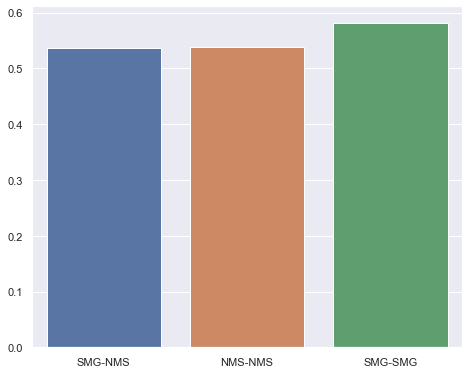

In [228]:
# ax = sns.barplot([imgs_sim_smg_nms.reshape(-1),
#              imgs_sim_nms_nms.reshape(-1),
#              imgs_sim_smg_smg.reshape(-1)],
#             errorbar=('ci', 95))
# ax.set_xticklabels(['SMG-NMS','NMS-NMS','SMG-SMG'])

[Text(0, 0, 'SMG-NMS'), Text(1, 0, 'NMS-NMS'), Text(2, 0, 'SMG-SMG')]

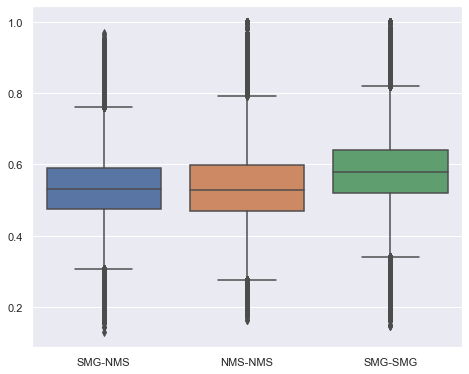

In [230]:
# ax = sns.boxplot([imgs_sim_smg_nms.reshape(-1),
#              imgs_sim_nms_nms.reshape(-1),
#              imgs_sim_smg_smg.reshape(-1)])
# ax.set_xticklabels(['SMG-NMS','NMS-NMS','SMG-SMG'])

<Axes: ylabel='Density'>

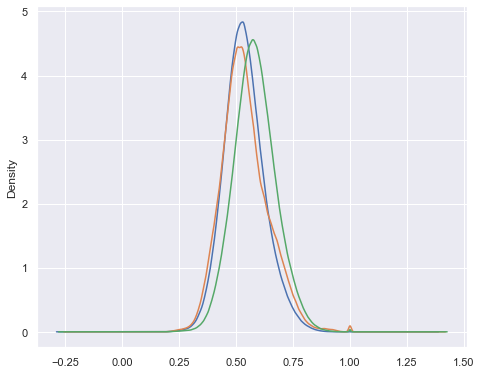

In [222]:
# pd.Series(imgs_sim_smg_nms.reshape(-1)).plot(kind='density')
# pd.Series(imgs_sim_nms_nms.reshape(-1)).plot(kind='density')
# pd.Series(imgs_sim_smg_smg.reshape(-1)).plot(kind='density')

In [207]:
#pd.Series(image_similarities.reshape(-1)).plot(kind='density')

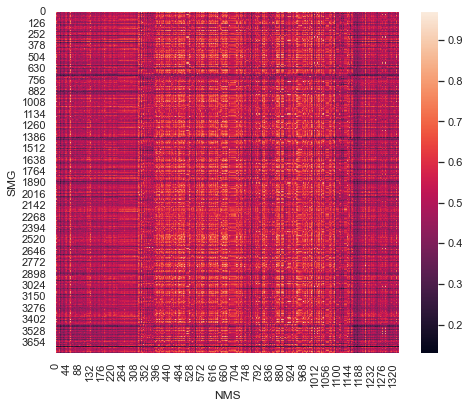

In [325]:
ax = sns.heatmap(image_similarities)
ax.set(xlabel='NMS', ylabel='SMG')
plt.show()

In [326]:
threshold = np.percentile(image_similarities.reshape(-1), 99.5) ; threshold

0.7947628429641663

<Axes: >

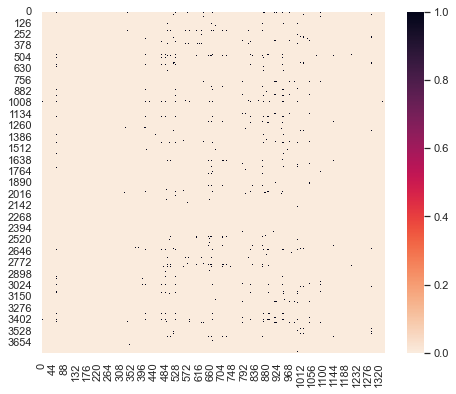

In [327]:
image_similarities[image_similarities >= threshold] = 1
image_similarities[image_similarities < threshold] = 0
sns.heatmap(image_similarities, cmap= sns.cm.rocket_r)

In [328]:
image_similarities.sum(axis=1).sum()

25313.0

In [330]:
(image_similarities.sum(axis=1).sum()/(image_similarities.shape[0]*image_similarities.shape[1]))*100

0.5000019752774277

In [331]:
connections = [(i,j) for i,j in zip(*np.where(image_similarities > 0))]

In [332]:
text_connections_with_rid = [(smg_rids[i],nms_rids[j]) for i,j in connections]

In [333]:
connections_with_rid[:10]

[('co33290', 'T.1966.3'),
 ('co33290', 'T.1915.11'),
 ('co8405136', 'T.1937.99'),
 ('co8405136', 'T.1938.140'),
 ('co8405136', 'T.1954.X.6'),
 ('co8405136', 'T.1961.68'),
 ('co8405136', 'T.1963.47'),
 ('co8405136', 'T.1965.42'),
 ('co8405136', 'T.1967.51'),
 ('co8405136', 'T.1967.52')]

In [334]:
len(connections_with_rid),len(set(connections_with_rid))

(50626, 50626)